In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号

import warnings
# 忽略警告提示
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 导入sklearn中常用的特征处理函数
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.decomposition import PCA

# 导入本次项目可能用到的机器学习模型
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 认识数据

In [2]:
# 导入数据
sou = pd.read_csv(r'train.csv')
pre = pd.read_csv(r'test.csv')
sou.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
pre.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# 将PassagerId用作索引，方便区分两个数据集
sou.set_index("PassengerId", inplace = True)
pre.set_index("PassengerId", inplace = True)

In [5]:
sou.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


# 特征分析

<AxesSubplot:>

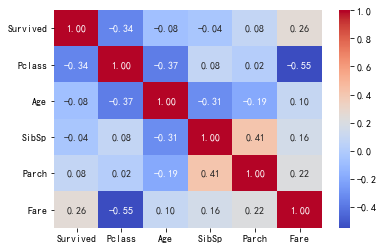

In [7]:
# 查看现有数字类型特征与Survived的协方差
sns.heatmap(sou[['Survived','Pclass','Age','SibSp','Parch','Fare']].corr(),\
            annot=True, fmt = ".2f", cmap = "coolwarm")

## 性别(Sex)

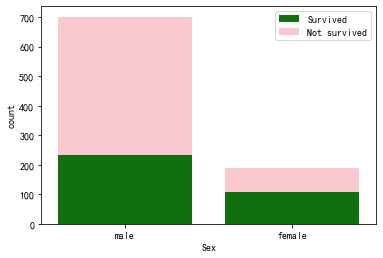

In [8]:
sns.countplot(x='Sex', data=sou.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Sex', data=sou.query('Survived == 0'), color='pink', bottom=sou.Sex[sou.Survived == 1].value_counts(), label='Not survived')
plt.legend()

## 舱室等级(Pclass)

In [9]:
sou.groupby(['Pclass','Survived']).Survived.count().to_frame()

Survived
Pclass Survived          
1      0               80
       1              136
2      0               97
       1               87
3      0              372
       1              119

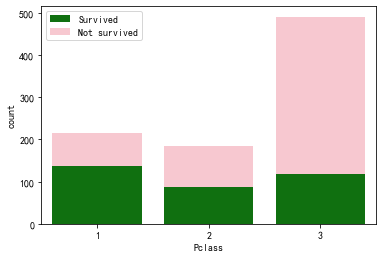

In [10]:
sns.countplot(x='Pclass', data=sou.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Pclass', data=sou.query('Survived == 0'), color='pink', bottom=sou.Pclass[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()

In [11]:
sou.SibSp.value_counts(sort=False).to_frame()

,SibSp
0,608
1,209
2,28
3,16
4,18
5,5
8,7


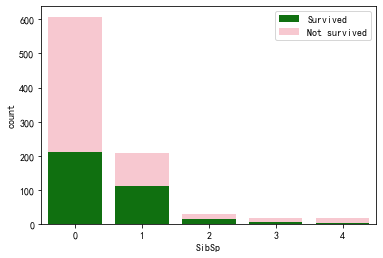

In [12]:
sou_sibsp_u5 = sou[sou.SibSp < 5]   # 数量过少的类型不具统计意义
sns.countplot(x='SibSp', data=sou_sibsp_u5.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='SibSp', data=sou_sibsp_u5.query('Survived == 0'), color='pink', bottom=sou_sibsp_u5.SibSp[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()

In [13]:
sou.Parch.value_counts(sort=False).to_frame()

,Parch
0,678
1,118
2,80
3,5
4,4
5,5
6,1


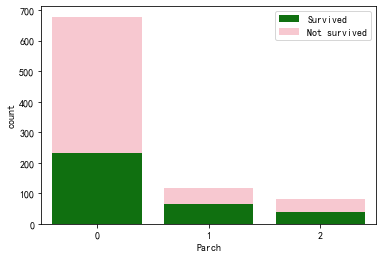

In [14]:
sou_parch_u5 = sou[sou.Parch < 3]   # 数量过少的类型不具统计意义
sns.countplot(x='Parch', data=sou_parch_u5.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Parch', data=sou_parch_u5.query('Survived == 0'), color='pink', bottom=sou_parch_u5.Parch[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()

## 年龄(Age)

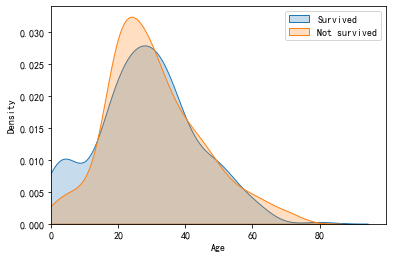

In [15]:
sns.kdeplot(data=sou.Age[sou.Survived == 1], shade=True, label='Survived')
sns.kdeplot(data=sou.Age[sou.Survived == 0], shade=True, label='Not survived')
plt.xlim(left=0)
plt.legend()

## 票号(Ticket)

In [16]:
pd.concat([sou, pre]).Ticket.describe().to_frame()

,Ticket
count,1309
unique,929
top,CA. 2343
freq,11


存在团体票，多人共用一组票

## 票价(Fare)

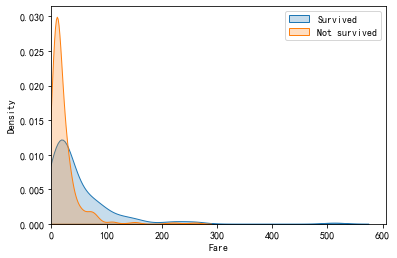

In [17]:
sns.kdeplot(data=sou.Fare[sou.Survived == 1], shade=True, label='Survived')
sns.kdeplot(data=sou.Fare[sou.Survived == 0], shade=True, label='Not survived')
plt.xlim(left=0)
plt.legend()

## 港口(Embarked)

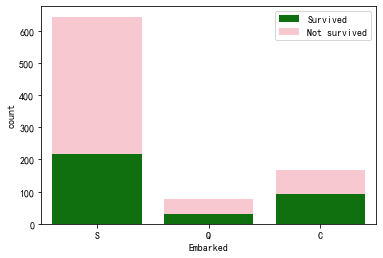

In [18]:
sns.countplot(x='Embarked', data=sou.query('Survived == 1'), order=['S', 'Q', 'C'], color='green', label='Survived')
sns.countplot(x='Embarked', data=sou.query('Survived == 0'), order=['S', 'Q', 'C'], color='pink', bottom=sou.Embarked[sou.Survived == 1].value_counts()[['S', 'Q', 'C']], label='Not survived')
plt.legend()

# 特征工程

In [19]:
sou_index = sou.index
pre_index = pre.index

full = pd.concat([sou, pre])
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


## 船票(Fare, Ticket)

In [20]:
# 取均值填充Fare缺失值
full.Fare = SimpleImputer(strategy='mean').fit_transform(full.Fare.to_frame())

In [21]:
# 硬编码
full.Ticket = LabelEncoder().fit_transform(full.Ticket)

## 姓名(Name)

In [22]:
full.Name.apply(lambda x: x.split(', ')[1].split('.')[0]).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [23]:
sou['Title'] = sou.Name.apply(lambda x: x.split(', ')[1].split('.')[0])

In [24]:
# 将title分成6类
title_map = {
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Jonkheer': 'Royalty',
    'Don': 'Royalty',
    'Sir': 'Royalty',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'the Countess': 'Royalty',
    'Dona': 'Royalty',
    'Mme': 'Mrs',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Lady': 'Royalty'
}

In [25]:
sou.Title = sou.Title.map(title_map)

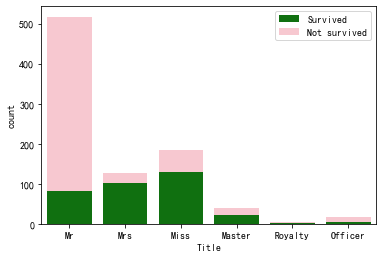

In [26]:
sns.countplot(x='Title', data=sou.query('Survived == 1'), order=sou.Title.unique(), color='green', label='Survived')
sns.countplot(x='Title', data=sou.query('Survived == 0'), order=sou.Title.unique(), color='pink', bottom=sou.Title[sou.Survived == 1].value_counts()[sou.Title.unique()], label='Not survived')
plt.legend()

In [27]:
full['Title'] = full.Name.apply(lambda x: x.split(', ')[1].split('.')[0])
full.Title = full.Title.map(title_map)

# 独热编码
full = pd.concat([full, pd.get_dummies(full.Title, prefix='Title')], axis=1)

## 性别(Sex)

In [28]:
full.Sex = full.Sex.map({'male': 0, 'female': 1}).astype('uint8')

In [29]:
full.loc[full.SibSp + full.Parch + 1 == 1, 'WithFamily'] = 0
full.loc[full.SibSp + full.Parch + 1 >= 2, 'WithFamily'] = 1
full.WithFamily = full.WithFamily.astype('uint8')
full.drop(columns=['SibSp', 'Parch'], inplace=True)
full.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,WithFamily
PassengerId,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,720,7.2500,NaN,S,Mr,0,0,1,0,0,0,1
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,816,71.2833,C85,C,Mrs,0,0,0,1,0,0,1
3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,914,7.9250,NaN,S,Miss,0,1,0,0,0,0,0
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,65,53.1000,C123,S,Mrs,0,0,0,1,0,0,1
5,0.0,3,"Allen, Mr. William Henry",0,35.0,649,8.0500,NaN,S,Mr,0,0,1,0,0,0,0


## 家庭组成(SibSp, Parch)

In [30]:
# 家庭成员总数 Family = SibSp + Parch + 1(self)

sou['Family'] = sou.SibSp + sou.Parch + 1
pre['Family'] = pre.SibSp + pre.Parch + 1

sou.Family.value_counts(sort=False).to_frame()

,Family
1,537
2,161
3,102
4,29
5,15
6,22
7,12
8,6
11,7


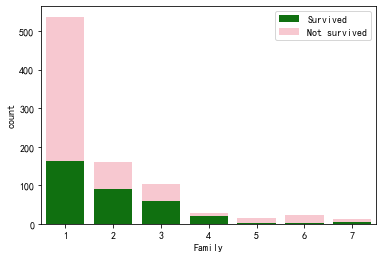

In [31]:
sou_family_u8 = sou[sou.Family < 8]   # 数量过少的类型不具统计意义
sns.countplot(x='Family', data=sou_family_u8.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Family', data=sou_family_u8.query('Survived == 0'), color='pink', bottom=sou_family_u8.Family[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()

In [32]:
# 单身为1类，小家庭（3人及以内）为2类，大家庭（3人以上）为3类
sou['FamilyType'] = 1
sou.loc[sou.Family >= 2, 'FamilyType'] = sou.Family[sou.Family >= 2].map(lambda x: 2 if x <= 3 else 3)

sou.FamilyType.value_counts(sort=False).to_frame()

,FamilyType
1,537
2,263
3,91


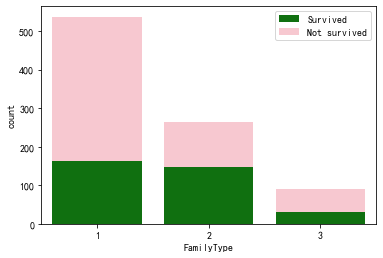

In [33]:
sns.countplot(x='FamilyType', data=sou.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='FamilyType', data=sou.query('Survived == 0'), color='pink', bottom=sou.FamilyType[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()

In [34]:
# 有家人为1，无家人为0
sou.loc[sou.Family == 1, 'WithFamily'] = 0
sou.loc[sou.Family >= 2, 'WithFamily'] = 1

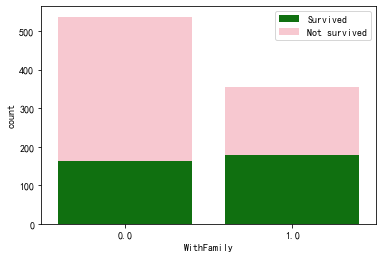

In [35]:
sns.countplot(x='WithFamily', data=sou.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='WithFamily', data=sou.query('Survived == 0'), color='pink', bottom=sou.WithFamily[sou.Survived == 1].value_counts()[::-1], label='Not survived')
plt.legend()

## 舱号(Cabin)

In [36]:
# 缺失严重直接删除
full.drop(columns='Cabin', inplace=True)

## 港口(Embarked)

,Embarked
S,914
C,270
Q,123


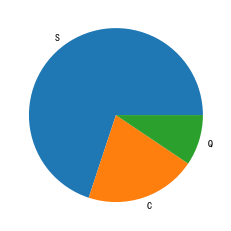

In [37]:
embarked_val_count = full.Embarked.value_counts()
plt.pie(embarked_val_count.values, labels=embarked_val_count.index)

full.Embarked.value_counts().to_frame()

In [38]:
# 取众数填充缺失值
full.Embarked = SimpleImputer(strategy='most_frequent').fit_transform(full.Embarked.to_frame())

In [39]:
# 独热编码
full = pd.concat([full, pd.get_dummies(full.Embarked, prefix='Embarked')], axis=1)

## 年龄(Age)

,Age
24.00,47
22.00,43
21.00,41
30.00,40
18.00,39
...,...
76.00,1
22.50,1
74.00,1
80.00,1


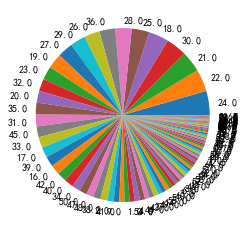

In [40]:
age_val_count = full.Age.value_counts()
plt.pie(age_val_count.values, labels=age_val_count.index)

full.Age.value_counts().to_frame()

In [41]:
# 取众数填充缺失值
full.Age = SimpleImputer(strategy='most_frequent').fit_transform(full.Age.to_frame())

In [42]:
# 以10岁为区间进行年龄分段
full.loc[full.Age != 'nan', 'AgeStage'] = (full.query('Age != "nan"').Age // 10).astype('uint8')

# 特征选择

In [43]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float64
 1   Pclass         1309 non-null   int64  
 2   Name           1309 non-null   object 
 3   Sex            1309 non-null   uint8  
 4   Age            1309 non-null   float64
 5   Ticket         1309 non-null   int32  
 6   Fare           1309 non-null   float64
 7   Embarked       1309 non-null   object 
 8   Title          1309 non-null   object 
 9   Title_Master   1309 non-null   uint8  
 10  Title_Miss     1309 non-null   uint8  
 11  Title_Mr       1309 non-null   uint8  
 12  Title_Mrs      1309 non-null   uint8  
 13  Title_Officer  1309 non-null   uint8  
 14  Title_Royalty  1309 non-null   uint8  
 15  WithFamily     1309 non-null   uint8  
 16  Embarked_C     1309 non-null   uint8  
 17  Embarked_Q     1309 non-null   uint8  
 18  Embarked

In [44]:
full.drop(columns=['Name', 'Embarked', 'Title'], inplace=True)

In [45]:
full.Pclass = full.Pclass.astype('uint8')

In [46]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float64
 1   Pclass         1309 non-null   uint8  
 2   Sex            1309 non-null   uint8  
 3   Age            1309 non-null   float64
 4   Ticket         1309 non-null   int32  
 5   Fare           1309 non-null   float64
 6   Title_Master   1309 non-null   uint8  
 7   Title_Miss     1309 non-null   uint8  
 8   Title_Mr       1309 non-null   uint8  
 9   Title_Mrs      1309 non-null   uint8  
 10  Title_Officer  1309 non-null   uint8  
 11  Title_Royalty  1309 non-null   uint8  
 12  WithFamily     1309 non-null   uint8  
 13  Embarked_C     1309 non-null   uint8  
 14  Embarked_Q     1309 non-null   uint8  
 15  Embarked_S     1309 non-null   uint8  
 16  AgeStage       1309 non-null   uint8  
dtypes: float64(3), int32(1), uint8(13)
memory usage: 62.

In [47]:
# 更新数据集
sou = full.loc[sou_index, :]
pre = full.loc[pre_index, :]

In [48]:
score = SelectKBest(f_classif).fit(sou.drop(columns='Survived'), sou.Survived).scores_
score = pd.Series(dict(zip(sou.columns[1:], score))).sort_values()

,0
Embarked_Q,0.011846
Title_Officer,0.872673
Title_Royalty,0.992285
AgeStage,2.315808
Age,2.492141
Title_Master,6.503635
Embarked_S,20.374460
Ticket,25.421096
Embarked_C,25.895987
WithFamily,38.353651


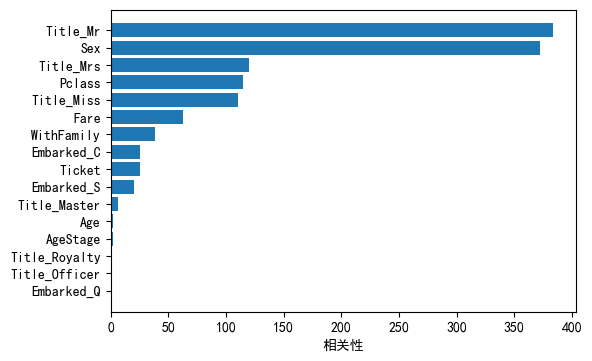

In [49]:
plt.figure(dpi = 100)
plt.barh(y=score.index, width=score.values)
plt.xlabel('相关性')

score.to_frame()

In [122]:
# 选择特征并归一化
full_mat = MinMaxScaler().fit_transform(full)

train_X = full_mat[sou_index - 1, 1:]
train_y = full_mat[sou_index - 1, 0].astype('uint8')

test_X = full_mat[pre_index - 1, 1:]

# 模型对比

In [134]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    '''
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    '''
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel('samples', fontsize=16)
        plt.ylabel('score', fontsize=16)
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color='b')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color='r')
        plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='train')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='test')

        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        plt.legend(loc='best')

        # plt.show()
        plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return train_scores_mean[-1], test_scores_mean[-1], midpoint, diff

In [139]:
def model_train(train_X, train_y, cv=3):
    #各个模型
    models = [LogisticRegression(), 
              SVC(), 
              RandomForestClassifier(), 
              AdaBoostClassifier(), 
              GradientBoostingClassifier(), 
              BaggingClassifier(), 
              VotingClassifier([('lr', LogisticRegression()), ('svc', SVC()), ('abc', AdaBoostClassifier())])]
    model_name = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'BaggingClassifier', 'VotingClassifier']

    scores = []
    #循环得到所有模型的训练结果
    for name, model in zip(model_name, models):
        # print(f'开始训练模型：{name})
        score = cross_val_score(model, train_X, train_y, cv=cv)

        model.fit(train_X, train_y)
        train_score, test_score, midpoint, diff = plot_learning_curve(model, name, train_X, train_y)

        scores.append([name, score.mean(), train_score, test_score, midpoint, diff])
        # print(f'{name} 得分:{score}')


    score_df = pd.DataFrame(scores, columns = ['model', 'score', 'train score', 'test score', 'midpoint', 'diff'])
    score_df.sort_values(by='score', inplace=True)

    return score_df

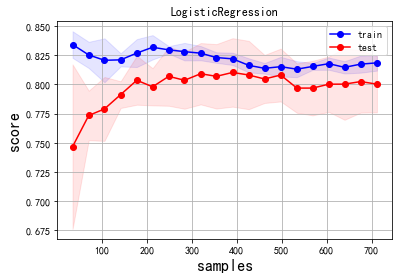

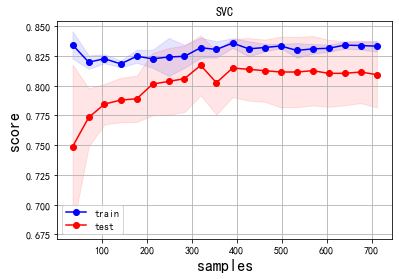

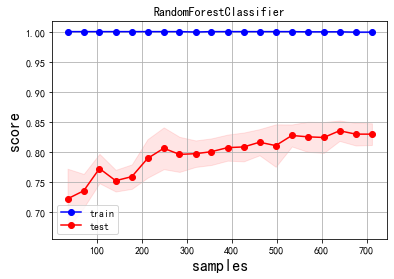

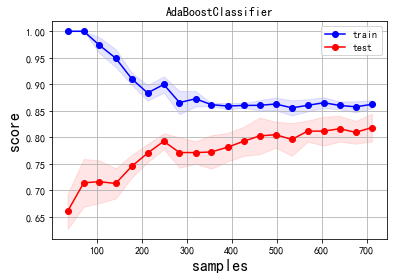

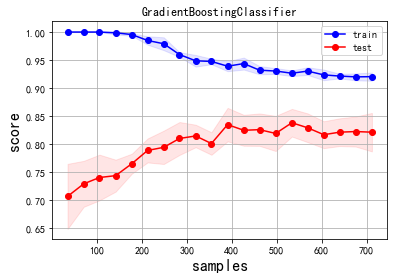

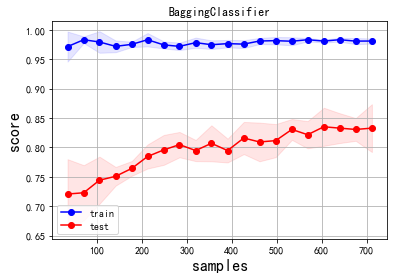

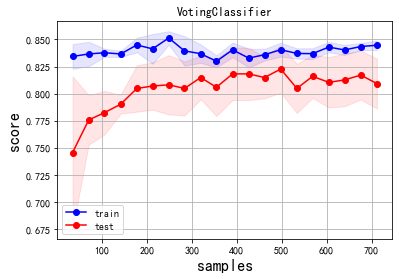

In [140]:
score_df = model_train(train_X, train_y, 5)

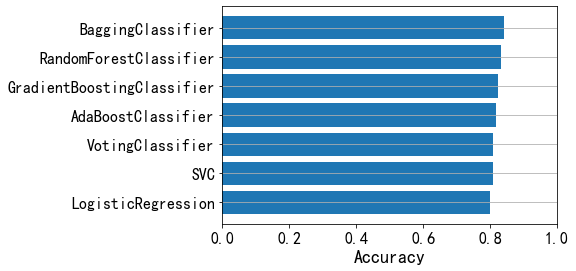

In [141]:
# 预测准确率可视化对比
plt.barh(score_df['model'], score_df['score'])
plt.xlim(0, 1)
plt.xlabel('Accuracy', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y')

# 模型预测

In [124]:
models = [LogisticRegression(), 
          SVC(), 
          RandomForestClassifier(), 
          AdaBoostClassifier(), 
          GradientBoostingClassifier(), 
          BaggingClassifier(), 
          VotingClassifier([('lr', LogisticRegression()), ('svc', SVC()), ('abc', AdaBoostClassifier())])]
model_name = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'BaggingClassifier', 'VotingClassifier']

for name, model in zip(model_name, models):
    model.fit(train_X, train_y)
    pre_sur = pre[['Survived']].copy()
    pre_sur.Survived = model.predict(test_X)
    pre_sur.to_csv(f'E:/Kaggle/Titanic/submission1/{name}.csv')